## Feature Selection with Mutual Information

The aim of this notebook:
- Look at column features and how they influence a cell's self-exciting property (mutual info)

In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer, get_data_sub_paths, pshape, get_data_resolutions
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup

from dataloaders.cell_loader import CellDataLoaders
from datasets.cell_dataset import CellDataGroup

from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from trainers.generic_trainer import train_model
from models.kangkang_fnn_models import train_epoch_for_fnn
from utils.configs import BaseConf
from utils.metrics import best_threshold, get_y_pred
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup

from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred, get_y_pred_by_thresholds, best_thresholds
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_all_models,\
                                get_models_metrics, get_models_results
from pprint import pprint
from time import time
from utils.setup import setup

In [20]:
conf = BaseConf()

conf.model_name = f"Mutual Info"

conf.data_path = f"./data/processed/{data_sub_path}/"

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

setup_logging(save_dir=conf.model_path,
              log_config='./logger/standard_logger_config.json',
              default_level=log.INFO)

with np.load(conf.data_path + "generated_data.npz") as zip_file:  # context helper ensures zip_file is closed
    sparse_crimes = zip_file["crime_types_grids"]
    crime_feature_indices = zip_file["crime_feature_indices"]


shaper = Shaper(data=sparse_crimes,
                conf=conf)

#     return conf, shaper, sparse_crimes, crime_feature_indices


In [2]:
data_sub_paths = get_data_sub_paths()
pprint(np.sort(data_sub_paths))

data_sub_path = 'T24H-X850M-Y880M_2013-01-01_2017-01-01'

array(['T12H-X850M-Y880M_2013-01-01_2017-01-01',
       'T1H-X1700M-Y1760M_2013-01-01_2017-01-01',
       'T24H-X1275M-Y1320M_2012-01-01_2019-01-01',
       'T24H-X1700M-Y1760M_2012-01-01_2019-01-01',
       'T24H-X255M-Y220M_2013-01-01_2017-01-01',
       'T24H-X425M-Y440M_2012-01-01_2019-01-01',
       'T24H-X425M-Y440M_2013-01-01_2017-01-01',
       'T24H-X850M-Y880M_2012-01-01_2019-01-01',
       'T24H-X850M-Y880M_2013-01-01_2017-01-01',
       'T24H-X85M-Y110M_2013-01-01_2017-01-01',
       'T3H-X850M-Y880M_2013-01-01_2017-01-01',
       'T6H-X850M-Y880M_2013-01-01_2017-01-01'], dtype='<U40')


In [3]:
conf, shaper, sparse_crimes, crime_feature_indices = setup(data_sub_path=data_sub_path)

In [4]:
from utils.preprocessing import Shaper

In [5]:
for i,k in enumerate(crime_feature_indices):
    print(f"'{k}':{i},")

'TOTAL':0,
'THEFT':1,
'BATTERY':2,
'CRIMINAL DAMAGE':3,
'NARCOTICS':4,
'ASSAULT':5,
'BURGLARY':6,
'MOTOR VEHICLE THEFT':7,
'ROBBERY':8,
'Arrest':9,


In [6]:
i = 0
crimes = sparse_crimes[:,i:i+1]
print(conf.shaper_threshold) # sum over all time should be above this threshold
print(conf.shaper_top_k) # if larger than 0 we filter out only the top k most active cells of the data grid
new_shaper = Shaper(crimes, conf)

0
-1


In [11]:
dense_crimes = shaper.squeeze(sparse_crimes)
from utils.utils import describe_array

In [19]:
print(describe_array(dense_crimes[:,4]))

____________________________________________________________
{'max': 43.0,
 'mean': 0.084798899185383,
 'min': 0.0,
 'shape': (1461, 772),
 'std': 0.37116642461852944}
____________________________________________________________


In [56]:
dense_crimes[dense_crimes > 0] = 1

In [57]:
c_now = dense_crimes[:-1,1:-1]
c_prev = dense_crimes[1:,1:-1]

In [58]:
c_now_flt = np.reshape(c_now.swapaxes(1,2),(-1,8))
c_prev_flt = np.reshape(c_prev.swapaxes(1,2),(-1,8))

In [59]:
df_now = pd.DataFrame(c_now_flt,columns=crime_feature_indices[1:-1])
df_prev = pd.DataFrame(c_prev_flt,columns=crime_feature_indices[1:-1])

In [60]:
df_now.corr()

,THEFT,BATTERY,CRIMINAL DAMAGE,NARCOTICS,ASSAULT,BURGLARY,MOTOR VEHICLE THEFT,ROBBERY
THEFT,1.000000,0.105854,0.075943,0.068029,0.066417,0.050817,0.047021,0.060383
BATTERY,0.105854,1.000000,0.101798,0.139691,0.104406,0.061343,0.049696,0.079825
CRIMINAL DAMAGE,0.075943,0.101798,1.000000,0.074156,0.061469,0.051847,0.038608,0.047310
NARCOTICS,0.068029,0.139691,0.074156,1.000000,0.086472,0.047265,0.044761,0.069765
ASSAULT,0.066417,0.104406,0.061469,0.086472,1.000000,0.036869,0.031553,0.050848
BURGLARY,0.050817,0.061343,0.051847,0.047265,0.036869,1.000000,0.028230,0.033261
MOTOR VEHICLE THEFT,0.047021,0.049696,0.038608,0.044761,0.031553,0.028230,1.000000,0.029594
ROBBERY,0.060383,0.079825,0.047310,0.069765,0.050848,0.033261,0.029594,1.000000


In [66]:
X = dense_crimes[:-1,:-1].swapaxes(1,2).reshape(-1,9)
y = dense_crimes[1:,0].reshape(-1)
y[y > 0] = 1
from sklearn.feature_selection import mutual_info_classif

In [67]:
mutual_info_classif(X,y)

array([0.07804144, 0.02078052, 0.02245209, 0.01046461, 0.01601758,
       0.0073597 , 0.00517525, 0.00221414, 0.00494581])

# Interactive Plotly Plots

In [1]:
# importing ogirinal data
import pandas as pd
import numpy as np
import plotly.graph_objs as go

In [2]:
color_palette = ["#33a8c7","#52e3e1","#a0e426","#fdf148","#ffab00","#f77976","#f050ae","#d883ff","#9336fd"]

In [3]:
df = pd.read_csv("data/original/Crimes_Chicago_2001_to_2019.csv")
crime_type_counts = df['Primary Type'].value_counts()
crime_types = list(crime_type_counts.index)[:len(color_palette)]
df = df[df['Primary Type'].isin(crime_types)]
df = df[[
 'ID',
 'Date',
 'Primary Type',
 'Arrest',
 'Year',
 'Latitude',
 'Longitude',
 'Census Tracts',
]].dropna()

df['Date'] = pd.to_datetime(df['Date'])

In [4]:
color_map = {k:v for k,v in zip(crime_types, color_palette)}
def get_color(t):
    return color_map.get(t, '#f050ae')

df['crime_c'] = df['Primary Type'].apply(get_color).to_list()

In [67]:
d = df.query('Year == 2014').sample(n=24000)
lat = d['Latitude']
lon = d['Longitude']
label = d[['Primary Type', 'Date']]
center = d[['Longitude', 'Latitude']].mean()
c = d['crime_c']
n = len(d)
print(len(d))
d.columns.to_list()

24000


['ID',
 'Date',
 'Primary Type',
 'Arrest',
 'Year',
 'Latitude',
 'Longitude',
 'Census Tracts',
 'crime_c']

In [68]:
mapbox_access_token = open(".mapbox_token").read()
mapbox_access_token

'pk.eyJ1IjoiYmVybnNibGFjayIsImEiOiJjajFidWIyZmgwMDRpMzJwZmd3NW90dDM4In0.dpYqqUJsBxuc6DBqTsHFJw\n'

In [69]:
from ipywidgets import widgets

In [101]:
d.reindex(axis='Date').index

Int64Index([1242097, 1387640, 1267754, 1350526, 1440837, 1221929, 1291526,
            1337814, 1318163, 1356655,
            ...
            1334811, 1409101, 1219950, 1262991, 1320815, 1455033, 1232123,
            1233096, 1440912, 1380190],
           dtype='int64', length=24000)

In [88]:
on_state = ('#f050ae', 8)
off_state = ('#ffab00', 8)

mapbox_styles = {
    "sat": "mapbox://styles/bernsblack/ckecz0wr52pfc1at7tvu43fmj", 
    "mono": "mapbox://styles/bernsblack/ckecyyizy065w19psrikmeo5d",
    "dark": "mapbox://styles/bernsblack/ckeikbchd254619s57np6iyum",
}

curve = go.Scatter(
    x=[0,1,2],
    y=[1,2,3],
    name='mean over time',
    xaxis='x2',
    yaxis='y2',
)

scatter = go.Scattermapbox(
        lat=lat.to_numpy(),
        lon=lon.to_numpy(),
        mode='markers',
        marker=dict(
            color=[off_state[0]]*n,
            size=[off_state[1]]*n,
            opacity=[0.7]*n,
        ),
        text=label,
)

# scatter = go.Scatter(
# #         lon=lon,    
# #         lat=lat,
#         x=lon,    
#         y=lat,
#         mode='markers',
#         marker=dict(
#             color=[off_state[0]]*n,
#             size=[off_state[1]]*n,
#             opacity=[0.6]*n,
#         ),
#         text=label,
# )


ybins = dict(start=lat.min(),end=lat.max()+.1,size=.001)
xbins = dict(start=lon.min(),end=lon.max()+.1, size=.001)
hist = go.Histogram2d(x=lon,y=lat, xbins=xbins, ybins=ybins, name='hist')


layout = go.Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=center.Latitude,
            lon=center.Longitude,
        ),
#         style=mapbox_styles["mono"],
#         style=mapbox_styles["dark"],    
        style=mapbox_styles["sat"],
        pitch=0,
        zoom=9,
        domain={'x': [0.0, 0.3], 'y': [0, 1]},
    ),
    height=700, 
#     width=1200,
    
    xaxis=dict(
        domain=[0, 0.3],
    ),
    xaxis2=dict(
        domain=[0.4, 1.0],
    ),
    yaxis2=dict(
        domain=[0.0, 1.0],
        anchor="x2",
    ),
)

fig = go.FigureWidget(data=[scatter, curve], layout=layout)
scatter = fig.data[0]
curve = fig.data[1]

selected = []
prev_select = []
t = 0
def select_fn(trace, points, selector):
    global t
    c = list(trace.marker.color)
    s = list(trace.marker.size)

    for i in prev_select:
        c[i], s[i] = off_state        

    for i in points.point_inds:
        c[i], s[i] = on_state  
    
#     mid_x = np.mean(points.xs)
#     mid_y = np.mean(points.ys)
    
    with fig.batch_update():
#         f.title = f"Mid point of selected is {(mid_x, mid_y)}"
        trace.marker.color = c
        trace.marker.size = s
        curve.x = np.arange(1000)
        curve.y = np.random.randn(1000)

    selected.clear()
    prev_select.clear()
    selected.append([trace, points, selector])
    prev_select.extend(points.point_inds)
        
    
scatter.on_selection(select_fn)
# scatter.on_hover(select_fn)


crime_types_dropdown = widgets.Dropdown(
    options=['ALL',*crime_types],
    value='ALL',
    description='Crime Type:',
)

month_slider = widgets.IntSlider(
    value=1.0,
    min=1.0,
    max=12.0,
    step=1.0,
    description='Month:',
    continuous_update=True
)

chng = 0
def widget_callback(change):
    global chng
    chng = change
    
    selected_crime_type = crime_types_dropdown.value
    if selected_crime_type != 'ALL':
        mask = d["Primary Type"] == selected_crime_type
        filtered = d[mask]
        text = label[mask]
    else:
        filtered = d
        text = label
    
    selected_month = month_slider.value
    if selected_month:
        mask = filtered['Date'].map(lambda x: x.month) == selected_month
        filtered = filtered[mask]
        text = text[mask]
        
    
    with fig.batch_update():
        scatter.lon = filtered.Longitude
        scatter.lat = filtered.Latitude
        scatter.text = text
#     scatter.marker.color = get_color(selected)


crime_types_dropdown.observe(widget_callback, names="value")
month_slider.observe(widget_callback, names="value")


play_button = widgets.Play(
    value=1,
    min=1,
    max=12,
    step=1,
    interval=500,
    description="Press play",
    disabled=False
)

widgets.jslink((play_button, 'value'), (month_slider, 'value'))


container = widgets.HBox([month_slider, crime_types_dropdown])
widgets.VBox([
    play_button,
    container,
    fig,
])

[[Scattermapbox({
      'lat': array([41.8031145 , 41.89606348, 41.7647071 , ..., 41.80067148, 41.85654706,
                    41.96116783]),
      'lon': array([-87.66774671, -87.66790274, -87.62489091, ..., -87.62585923,
                    -87.69560453, -87.71002676]),
      'marker': {'color': [#f050ae, #ffab00, #f050ae, ..., #ffab00, #ffab00,
                           #ffab00],
                 'opacity': [0.7, 0.7, 0.7, ..., 0.7, 0.7, 0.7],
                 'size': [8, 8, 8, ..., 8, 8, 8]},
      'mode': 'markers',
      'selectedpoints': [0, 2, 5, ..., 638, 642, 643],
      'text': array([['THEFT', Timestamp('2014-07-15 22:30:00')],
                     ['THEFT', Timestamp('2014-07-21 15:00:00')],
                     ['THEFT', Timestamp('2014-07-27 02:00:00')],
                     ...,
                     ['THEFT', Timestamp('2014-07-27 11:30:00')],
                     ['THEFT', Timestamp('2014-07-24 15:00:00')],
                     ['THEFT', Timestamp('2014-07-22 23:25:0

In [71]:
nx = 10
ny = 10
z = np.random.randint(0,10,(nx,ny))
x = np.arange(nx)
y = np.arange(ny)

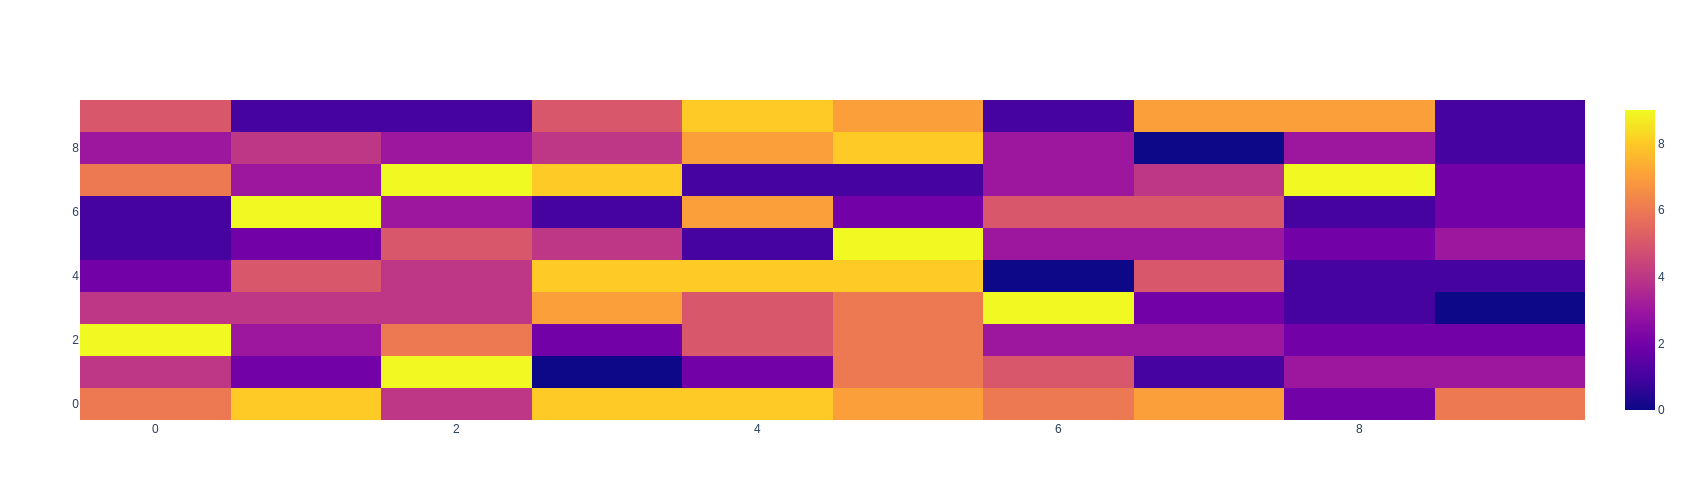

In [76]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=z,
                   x=x,
                   y=y,
                   hoverongaps = True), layout_height=500, layout_width=500)
fig.show()

In [78]:
fig.data[0]

Heatmap({
    'hoverongaps': True,
    'x': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
    'y': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
    'z': array([[6, 8, 4, 8, 8, 7, 6, 7, 2, 6],
                [4, 2, 9, 0, 2, 6, 5, 1, 3, 3],
                [9, 3, 6, 2, 5, 6, 3, 3, 2, 2],
                [4, 4, 4, 7, 5, 6, 9, 2, 1, 0],
                [2, 5, 4, 8, 8, 8, 0, 5, 1, 1],
                [1, 2, 5, 4, 1, 9, 3, 3, 2, 3],
                [1, 9, 3, 1, 7, 2, 5, 5, 1, 2],
                [6, 3, 9, 8, 1, 1, 3, 4, 9, 2],
                [3, 4, 3, 4, 7, 8, 3, 0, 3, 1],
                [5, 1, 1, 5, 8, 7, 1, 7, 7, 1]])
})